# Sparse Matrices

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('notebook', font_scale=1.5)

## Creating a sparse matrix

There are many applications in which we deal with matrices that are mostly zeros. For example, a matrix representing social networks is very sparse - there are 7 billion people, but most people are only connected to a few hundred or thousand others directly. Storing such a social network as a sparse rather than dense matrix  will offer orders of magnitude reductions in memory requirements and corresponding speed-ups in computation.

### Coordinate format

The simplest sparse  matrix format is built from the coordinates and values of the non-zero entries.

#### From dense matrix

In [3]:
A = np.random.poisson(0.2, (5,15)) * np.random.randint(0, 10, (5, 15))
A

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0],
       [ 0,  1,  8,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  7,  0,  0,  6,  0,  4,  1,  0,  5],
       [ 0,  0,  0,  0,  0,  9,  8,  0,  0,  2,  0,  0,  0,  5,  0]])

In [4]:
rows, cols = np.nonzero(A)
vals = A[rows, cols]

In [5]:
vals

array([18,  1,  8,  5,  2,  7,  6,  4,  1,  5,  9,  8,  2,  5])

In [6]:
rows

array([0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4])

In [7]:
cols

array([11,  1,  2,  5,  4,  6,  9, 11, 12, 14,  5,  6,  9, 13])

In [8]:
X1 = sparse.coo_matrix(A)
X1

<5x15 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in COOrdinate format>

In [9]:
print(X1)

  (0, 11)	18
  (1, 1)	1
  (1, 2)	8
  (1, 5)	5
  (2, 4)	2
  (3, 6)	7
  (3, 9)	6
  (3, 11)	4
  (3, 12)	1
  (3, 14)	5
  (4, 5)	9
  (4, 6)	8
  (4, 9)	2
  (4, 13)	5


#### From coordinates

Note that the (values, (rows, cols)) argument is a single tuple.

In [10]:
X2 = sparse.coo_matrix((vals, (rows, cols)))
X2

<5x15 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in COOrdinate format>

In [11]:
print(X2)

  (0, 11)	18
  (1, 1)	1
  (1, 2)	8
  (1, 5)	5
  (2, 4)	2
  (3, 6)	7
  (3, 9)	6
  (3, 11)	4
  (3, 12)	1
  (3, 14)	5
  (4, 5)	9
  (4, 6)	8
  (4, 9)	2
  (4, 13)	5


#### Convert back to dense matrix

In [12]:
X2.todense()

matrix([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0],
        [ 0,  1,  8,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  7,  0,  0,  6,  0,  4,  1,  0,  5],
        [ 0,  0,  0,  0,  0,  9,  8,  0,  0,  2,  0,  0,  0,  5,  0]])

### Compressed Sparse Row and Column formats

When we have 3 or more repeated entries in the rows or cols, we can remove the redundancy by indicating the  location of the  first occurrence of a value and its increment instead of the full coordinates. These are known as CSR or CSC formats.

In [13]:
np.vstack([rows, cols])

array([[ 0,  1,  1,  1,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4],
       [11,  1,  2,  5,  4,  6,  9, 11, 12, 14,  5,  6,  9, 13]])

In [14]:
indptr = np.r_[np.searchsorted(rows, np.unique(rows)), len(rows)]
indptr

array([ 0,  1,  4,  5, 10, 14])

In [15]:
X3 = sparse.csr_matrix((vals, cols, indptr))
X3

<5x15 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [16]:
X3.todense()

matrix([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0],
        [ 0,  1,  8,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  7,  0,  0,  6,  0,  4,  1,  0,  5],
        [ 0,  0,  0,  0,  0,  9,  8,  0,  0,  2,  0,  0,  0,  5,  0]])

#### Casting from COO format

Because the coordinate format is more intuitive, it is often more convenient to first create a COO matrix then cast to CSR or CSC form.

In [17]:
X4 = X2.tocsr()

In [18]:
X4

<5x15 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

### COO summation convention

When entries are repeated in a COO matrix, they are **summed**. This provides a quick way to construct confusion matrices for evaluation of multi-class  classification algorithms.

In [19]:
rows = np.r_[np.zeros(4), np.ones(4)]
cols = np.repeat([0,1], 4)
vals = np.arange(8)

In [20]:
rows

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.])

In [21]:
cols

array([0, 0, 0, 0, 1, 1, 1, 1])

In [22]:
vals

array([0, 1, 2, 3, 4, 5, 6, 7])

In [23]:
X5 = sparse.csr_matrix((vals, (rows, cols)))

In [24]:
print(X5)

  (0, 0)	6
  (1, 1)	22


## Application: Confusion matrix

### Creating a 2 by 2 confusion matrix

In [25]:
obs = np.random.randint(0, 2, 100)
pred = np.random.randint(0, 2, 100)
vals = np.ones(100).astype('int')

In [26]:
pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0])

In [27]:
vals.shape, obs.shape , pred.shape

((100,), (100,), (100,))

In [28]:
X6 = sparse.coo_matrix((vals, (pred, obs)))

In [29]:
X6.todense()

matrix([[26, 29],
        [25, 20]])

#### Creating an $n$ by $n$ confusion matrix

For classifications with a large number of classes (e.g. image segmentation),  the savings are even more dramatic.

In [30]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [31]:
iris = datasets.load_iris()

In [32]:
knn = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                    test_size=0.5, random_state=42)

In [33]:
pred = knn.fit(X_train, y_train).predict(X_test)

In [34]:
X7 = sparse.coo_matrix((np.ones(len(pred)).astype('int'), (pred, y_test)))
pd.DataFrame(X7.todense(), index=iris.target_names, columns=iris.target_names)

,setosa,versicolor,virginica
setosa,29,0,0
versicolor,0,23,4
virginica,0,0,19


## Application: PageRank

SciPy provides efficient routines for solving large sparse systems as for dense matrices. We will illustrate by calculating the page rank  for airports using data from the [Bureau of Transportation Statisitcs](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236).

In [35]:
data = pd.read_csv('data/airports.csv', usecols=[0,1])

In [36]:
data.shape

(445827, 2)

In [37]:
data.head()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID
0,10135,10397
1,10135,10397
2,10135,10397
3,10135,10397
4,10135,10397


In [38]:
lookup = pd.read_csv('data/names.csv', index_col=0)

In [39]:
lookup.shape

(6404, 1)

In [40]:
lookup.head()

,Description
Code,
10001,"Afognak Lake, AK: Afognak Lake Airport"
10003,"Granite Mountain, AK: Bear Creek Mining Strip"
10004,"Lik, AK: Lik Mining Camp"
10005,"Little Squaw, AK: Little Squaw Airport"
10006,"Kizhuyak, AK: Kizhuyak Bay"


In [41]:
import networkx as nx

#### Construct the sparse adjacency matrix

In [42]:
g = nx.from_pandas_dataframe(data, source='ORIGIN_AIRPORT_ID', target='DEST_AIRPORT_ID')

In [43]:
airports = np.array(g.nodes())
adj_matrix = nx.to_scipy_sparse_matrix(g)

#### Construct the transition matrix

In [44]:
out_degrees = np.ravel(adj_matrix.sum(axis=1))
diag_matrix = sparse.diags(1 / out_degrees).tocsr()
M = (diag_matrix @ adj_matrix).T

#### Modify the transition matrix with a damping factor

The PageRank algorithm assumes that every node can be reached from every other node. To guard against case where a node has out-degree 0, we allow every node a small random chance of transitioning to any other node using a damping factor $d$. Then we solve  the linear system  to find the pagerank score $r$.

$$
r = (I - dM)^{-1}\frac{1-d}{N}\mathbb{1}
$$

or equivalently in the $Ax = b$ format

$$
(I - dM)r = \frac{1-d}{N}\mathbb{1}
$$

In [45]:
n = len(airports) 
d = 0.85 
I = sparse.eye(n, format='csc')
A = I - d * M
b = (1-d) / n * np.ones(n) # so the sum of all page ranks is 1

In [46]:
A.todense()

matrix([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [47]:
from scipy.sparse.linalg import spsolve

In [48]:
r =  spsolve(A, b)
r.sum()

0.99999999999999978

In [49]:
idx = np.argsort(r)

In [50]:
top10 = idx[-10:][::-1]
bot10 = idx[:10]

In [51]:
df = lookup.loc[airports[top10]]
df['degree'] = out_degrees[top10]
df['pagerank']= r[top10]
df

,Description,degree,pagerank
Code,,,
10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",158,0.043286
13930,"Chicago, IL: Chicago O'Hare International",139,0.033956
11292,"Denver, CO: Denver International",129,0.031434
11298,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",108,0.027596
13487,"Minneapolis, MN: Minneapolis-St Paul Internati...",108,0.027511
12266,"Houston, TX: George Bush Intercontinental/Houston",110,0.025967
11433,"Detroit, MI: Detroit Metro Wayne County",100,0.024738
14869,"Salt Lake City, UT: Salt Lake City International",78,0.019298
14771,"San Francisco, CA: San Francisco International",76,0.017820


In [52]:
df = lookup.loc[airports[bot10]]
df['degree'] = out_degrees[bot10]
df['pagerank']= r[bot10]
df

,Description,degree,pagerank
Code,,,
12265,"Niagara Falls, NY: Niagara Falls International",1,0.000693
14025,"Plattsburgh, NY: Plattsburgh International",1,0.000693
11695,"Flagstaff, AZ: Flagstaff Pulliam",1,0.000693
16218,"Yuma, AZ: Yuma MCAS/Yuma International",1,0.000693
14905,"Santa Maria, CA: Santa Maria Public/Capt. G. A...",1,0.000710
13964,"North Bend/Coos Bay, OR: Southwest Oregon Regi...",1,0.000710
10157,"Arcata/Eureka, CA: Arcata",1,0.000710
14487,"Redding, CA: Redding Municipal",1,0.000710
12177,"Hobbs, NM: Lea County Regional",1,0.000711


#### Visualize the airport connections graph and label the top and bottom 5 airports by pagerank

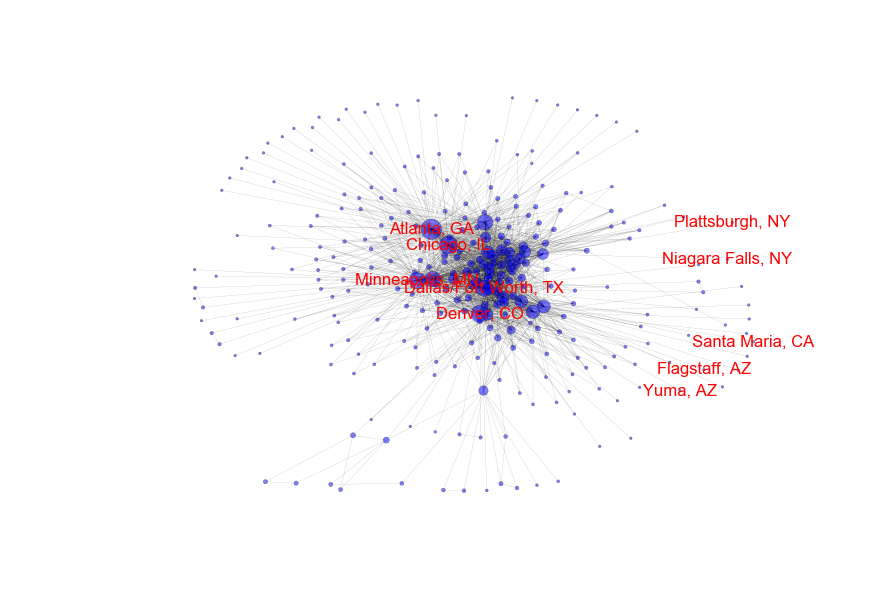

In [53]:
labels = {airports[i]: lookup.loc[airports[i]].str.split(':').str[0].values[0] 
          for i in np.r_[top10[:5], bot10[:5]]}
nx.draw(g, pos=nx.spring_layout(g), labels=labels, 
        node_color='blue', font_color='red', alpha=0.5,
        node_size=np.clip(5000*r, 1, 5000*r), width=0.1)